# **Import Libraries**

In [1]:
 # Basic
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter


# TensorFlow and Keras
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.models import load_model
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, History

# Keras Tuner
import keras_tuner as kt

# Scikit-Learn
from sklearn.utils.class_weight import compute_class_weight
from sklearn.metrics import (
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report,
    ConfusionMatrixDisplay
)

## **HyperParameter Tunning**

In [2]:
BATCH_SIZE = 64  # Set this based on your system's capacity
IMAGE_SIZE = 128  # Standard input size for MobileNetV2
CHANNELS = 3
EPOCHS = 50

In [3]:
DATASET_DIR = 'with_augmentation'

dataset = tf.keras.preprocessing.image_dataset_from_directory(
    DATASET_DIR,
    shuffle=True,
    image_size=(IMAGE_SIZE, IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 61486 files belonging to 39 classes.


#### **CLASS_NAMES**

In [4]:
class_names = dataset.class_names
n_classes = len(class_names)
class_names

['Apple___Apple_scab',
 'Apple___Black_rot',
 'Apple___Cedar_apple_rust',
 'Apple___healthy',
 'Background_without_leaves',
 'Blueberry___healthy',
 'Cherry___Powdery_mildew',
 'Cherry___healthy',
 'Corn___Cercospora_leaf_spot Gray_leaf_spot',
 'Corn___Common_rust',
 'Corn___Northern_Leaf_Blight',
 'Corn___healthy',
 'Grape___Black_rot',
 'Grape___Esca_(Black_Measles)',
 'Grape___Leaf_blight_(Isariopsis_Leaf_Spot)',
 'Grape___healthy',
 'Orange___Haunglongbing_(Citrus_greening)',
 'Peach___Bacterial_spot',
 'Peach___healthy',
 'Pepper,_bell___Bacterial_spot',
 'Pepper,_bell___healthy',
 'Potato___Early_blight',
 'Potato___Late_blight',
 'Potato___healthy',
 'Raspberry___healthy',
 'Soybean___healthy',
 'Squash___Powdery_mildew',
 'Strawberry___Leaf_scorch',
 'Strawberry___healthy',
 'Tomato___Bacterial_spot',
 'Tomato___Early_blight',
 'Tomato___Late_blight',
 'Tomato___Leaf_Mold',
 'Tomato___Septoria_leaf_spot',
 'Tomato___Spider_mites Two-spotted_spider_mite',
 'Tomato___Target_Spot'

(64, 128, 128, 3)
[30 36 31 11 25 18 16 23 36  7 36 32 16 33 33 17 25 31  3 34 25  1 25 23
 29  0  9 36 25  5 36 38 22 25 21  5 36 29 16 13 36 31 16 26 32 34 19 16
  3  0 36 13 25 24  9 34 26  0 19 32 13  1 37 18]


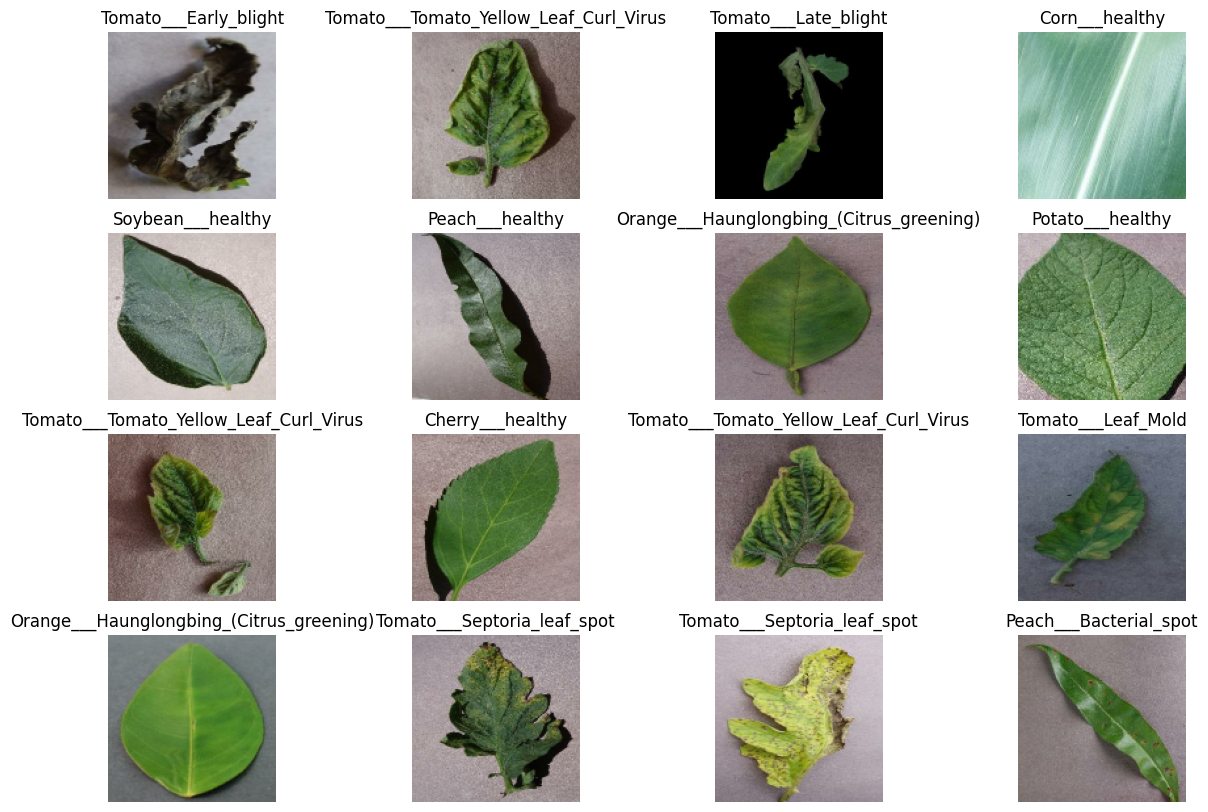

In [5]:
plt.figure(figsize=(15, 10))
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [6]:
def get_dataset_partitions_tf(ds, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000):
    assert (train_split + test_split + val_split) == 1
    ds_size = len(ds)

    if shuffle:
        ds = ds.shuffle(shuffle_size, seed=12)

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

train_ds, val_ds, test_ds = get_dataset_partitions_tf(dataset)

In [7]:
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds = val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds = test_ds.cache().prefetch(buffer_size=tf.data.AUTOTUNE)  # NO shuffle here

C:\Users\ASHISH\AppData\Local\Temp\ipykernel_11716\2253075128.py:15: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  bars = sns.barplot(x=class_names, y=counts, palette="deep")


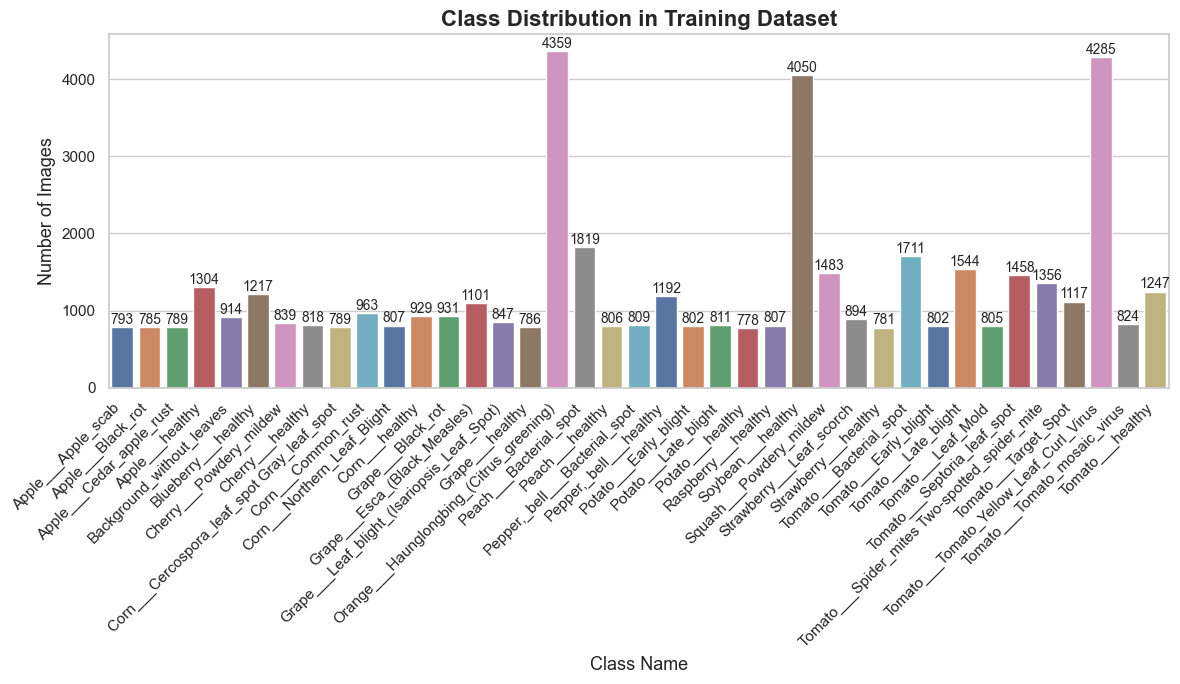

In [9]:
# Collect all labels in training set
train_labels = []
for images, labels in train_ds:
    train_labels.extend(labels.numpy())

# Count class occurrences
label_counts = Counter(train_labels)
counts = [label_counts[i] for i in range(n_classes)]

# Use Seaborn style
sns.set_theme(style="whitegrid")

# Create figure
plt.figure(figsize=(12, 7))
bars = sns.barplot(x=class_names, y=counts, palette="deep")

# Add value labels on top of each bar
for bar in bars.patches:
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 1,
        int(bar.get_height()),
        ha='center',
        va='bottom',
        fontsize=10
    )

# Fine-tune the plot
plt.xticks(rotation=45, ha='right', fontsize=11)
plt.yticks(fontsize=11)
plt.title("Class Distribution in Training Dataset", fontsize=16, fontweight='bold')
plt.xlabel("Class Name", fontsize=13)
plt.ylabel("Number of Images", fontsize=13)
plt.tight_layout()

# Save the figure in high resolution (for IEEE paper)
plt.savefig("class_distribution.png", dpi=600, bbox_inches='tight')

plt.show()

In [8]:
resize_and_rescale = tf.keras.Sequential([
    layers.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.Rescaling(1.0/255),
])

In [9]:
# Get all labels from the training set
train_labels = np.concatenate([y for x, y in train_ds], axis=0)

# Compute class weights (automatically balances rare classes)
class_weights = compute_class_weight(
    'balanced',
    classes=np.unique(train_labels),
    y=train_labels
)
class_weights = dict(enumerate(class_weights))

print("Class Weights:", class_weights)

Class Weights: {0: 1.5793329477540003, 1: 1.5388372311449234, 2: 1.5694989941565285, 3: 0.9672353739890194, 4: 1.3773854560739807, 5: 1.0338865400391242, 6: 1.5294996265870053, 7: 1.5872892850222824, 8: 1.5734178430807644, 9: 1.345045562761678, 10: 1.6325229174970108, 11: 1.3566283017305623, 12: 1.345045562761678, 13: 1.1541279233586925, 14: 1.4688900842746997, 15: 1.5407184502539026, 16: 0.28787293108901146, 17: 0.677949269665246, 18: 1.5892909108545932, 19: 1.5694989941565285, 20: 1.0698707065430326, 21: 1.5636571864859705, 22: 1.52027465899601, 23: 1.5521030693444486, 24: 1.585292694726657, 25: 0.31195734958111193, 26: 0.8515592515592516, 27: 1.416076058772688, 28: 1.5773563107730817, 29: 0.7370220422852002, 30: 1.5407184502539026, 31: 0.8264312736443884, 32: 1.6034449011548249, 33: 0.9126051356319278, 34: 0.927378728703232, 35: 1.122268648537571, 36: 0.29357272124567724, 37: 1.5655996177735307, 38: 0.9915874841130545}


### **Build Model with Tunable Hyperparameters**

In [10]:
# Function to build the model with tunable hyperparameters
def build_model(hp):
    IMAGE_SIZE = 128
    CHANNELS = 3
    inputs = layers.Input(shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))

    # MobileNetV2 Base Model
    base_model =MobileNetV2(weights='imagenet', include_top=False, input_shape=(IMAGE_SIZE, IMAGE_SIZE, CHANNELS))
    base_model.trainable = False  # Freeze base model layers

    x = resize_and_rescale(inputs)  # Resize and rescale the images
    x = base_model(x, training=False)
    x = layers.Flatten()(x)

    # Tune the Dense layer units and Dropout rate
    x = layers.Dense(hp.Int("dense_units", min_value=128, max_value=512, step=128), activation='relu')(x)
    x = layers.Dropout(hp.Float("dropout", min_value=0.3, max_value=0.6, step=0.1))(x)

    # Output layer
    outputs = layers.Dense(n_classes, activation='softmax')(x)

    model = Model(inputs, outputs)

    # Compile with tunable learning rate
    model.compile(
        optimizer=tf.keras.optimizers.Adam(
            learning_rate=hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])),
        loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
        metrics=['accuracy']
    )

    return model

In [11]:
# Hyperparameter Tuning
tuner = kt.Hyperband(
    build_model,
    objective='val_loss',  # Optimize for loss
    max_epochs=15,
    factor=3,
    directory='Val_Loss_Tunning',
    project_name='MobileNetV2_tuning'
)

In [12]:
# Early Stopping + Checkpointing
early_stopping = EarlyStopping(monitor='val_loss', patience=6, restore_best_weights=True, verbose=1)
checkpoint = ModelCheckpoint('Val_Loss_saved_models/Plant_Disease_MobileNetV2_tuning.h5', save_best_only=True, monitor='val_loss', verbose=1)

In [13]:
# Train with Class Weights
tuner.search(
    train_ds,
    validation_data=val_ds,
    epochs = 20,
    class_weight=class_weights,  # Critical for imbalance
    callbacks=[early_stopping, checkpoint]
)

Trial 18 Complete [00h 43m 09s]
val_loss: 0.02438502199947834

Best val_loss So Far: 0.02438502199947834
Total elapsed time: 03h 52m 05s

Search: Running Trial #19

Value             |Best Value So Far |Hyperparameter
512               |256               |dense_units
0.3               |0.5               |dropout
0.0001            |0.0001            |learning_rate
5                 |15                |tuner/epochs
0                 |5                 |tuner/initial_epoch
1                 |2                 |tuner/bracket
0                 |2                 |tuner/round

Epoch 1/5
768/768 [==============================] - ETA: 0s - loss: 0.5422 - accuracy: 0.8477
Epoch 1: val_loss improved from inf to 0.12168, saving model to Val_Loss_saved_models\Plant_Disease_MobileNetV2_tuning.h5
768/768 [==============================] - 170s 220ms/step - loss: 0.5422 - accuracy: 0.8477 - val_loss: 0.1217 - val_accuracy: 0.9646
Epoch 2/5
110/768 [===>..........................] - ETA: 2:06 - loss:

KeyboardInterrupt: 

In [14]:
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
print(f'Best Hyperparameters = {best_hps}')

Best Hyperparameters = <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x0000017EA593BDF0>


In [15]:
# Build the best model from the best hyperparameters
model = tuner.hypermodel.build(best_hps)
print(f'Best Model Summary:')
model.summary()

Best Model Summary:
Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 sequential (Sequential)     (None, 128, 128, 3)       0         
                                                                 
 mobilenetv2_1.00_128 (Funct  (None, 4, 4, 1280)       2257984   
 ional)                                                          
                                                                 
 flatten_1 (Flatten)         (None, 20480)             0         
                                                                 
 dense_2 (Dense)             (None, 256)               5243136   
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                       

In [16]:
# Retrieve the best model
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]
model = tuner.hypermodel.build(best_hps)

print(f'Best HPS = {best_hps}')
print(f'Model = {model}')

Best HPS = <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x0000017EA593BDF0>
Model = <keras.engine.functional.Functional object at 0x0000017EB610D400>


In [17]:
# Fit the model with the best hyperparameters
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    class_weight=class_weights,  # Critical for imbalance
    callbacks=[early_stopping, checkpoint],
    verbose = 1
)

Epoch 1/50
768/768 [==============================] - ETA: 0s - loss: 0.8854 - accuracy: 0.7552
Epoch 1: val_loss improved from inf to 0.17712, saving model to Val_Loss_saved_models\Plant_Disease_MobileNetV2_tuning.h5
768/768 [==============================] - 166s 215ms/step - loss: 0.8854 - accuracy: 0.7552 - val_loss: 0.1771 - val_accuracy: 0.9489
Epoch 2/50
768/768 [==============================] - ETA: 0s - loss: 0.3254 - accuracy: 0.8987
Epoch 2: val_loss improved from 0.17712 to 0.11382, saving model to Val_Loss_saved_models\Plant_Disease_MobileNetV2_tuning.h5
768/768 [==============================] - 160s 209ms/step - loss: 0.3254 - accuracy: 0.8987 - val_loss: 0.1138 - val_accuracy: 0.9660
Epoch 3/50
768/768 [==============================] - ETA: 0s - loss: 0.2163 - accuracy: 0.9305
Epoch 3: val_loss improved from 0.11382 to 0.06778, saving model to Val_Loss_saved_models\Plant_Disease_MobileNetV2_tuning.h5
768/768 [==============================] - 159s 207ms/step - loss: 0

In [18]:
import pickle
with open('Val_Loss_saved_models/Plant_Disease_MobileNetV2_tuning_training_history.pkl', 'wb') as f:
    pickle.dump(history.history, f)

In [19]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

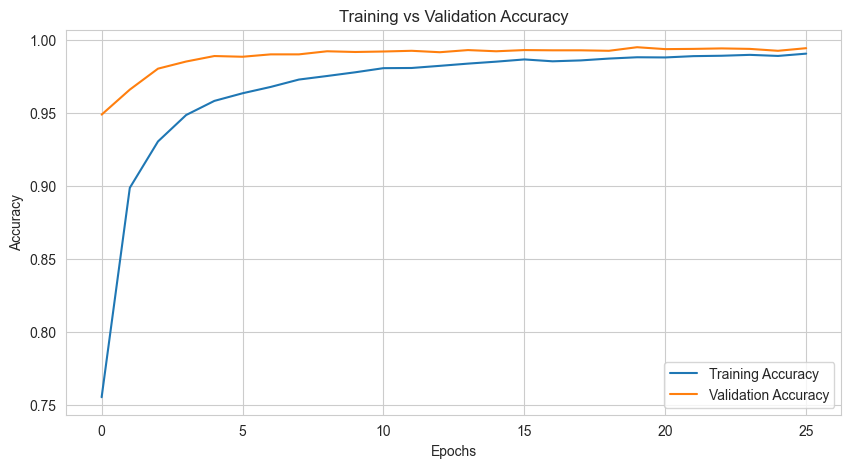

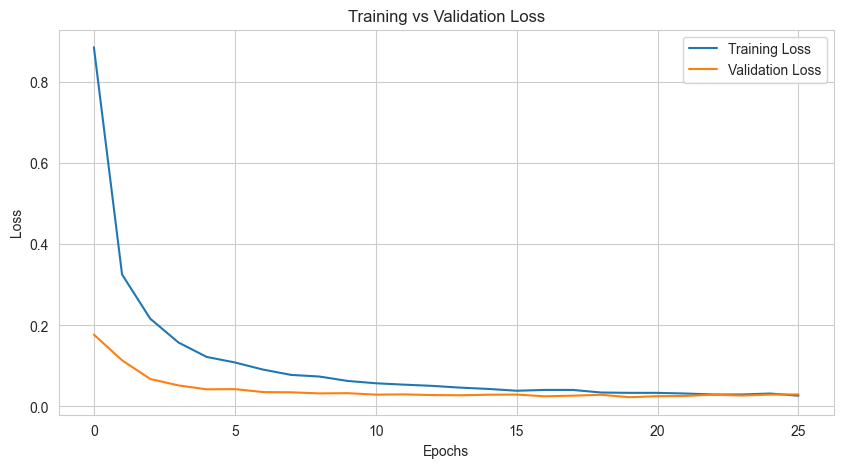

In [20]:
# Accuracy plot
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.title('Training vs Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)
plt.show()

# Loss plot
sns.set_style("whitegrid")
plt.figure(figsize=(10,5))
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training vs Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()

In [21]:
# Evaluate
test_loss, test_accuracy = model.evaluate(test_ds)
print(f"\nTest Accuracy: {test_accuracy*100:.2f}%")

97/97 [==============================] - 67s 197ms/step - loss: 0.0262 - accuracy: 0.9939

Test Accuracy: 99.39%


#### **Prediction Function**

In [22]:
# Prediction Function
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)

    predictions = model.predict(img_array)  # Make predictions

    # Identify the predicted class with the highest confidence
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * np.max(predictions[0]), 2)
    return predicted_class, confidence

#### **Predictions**

1/1 [==============================] - 0s 25ms/step


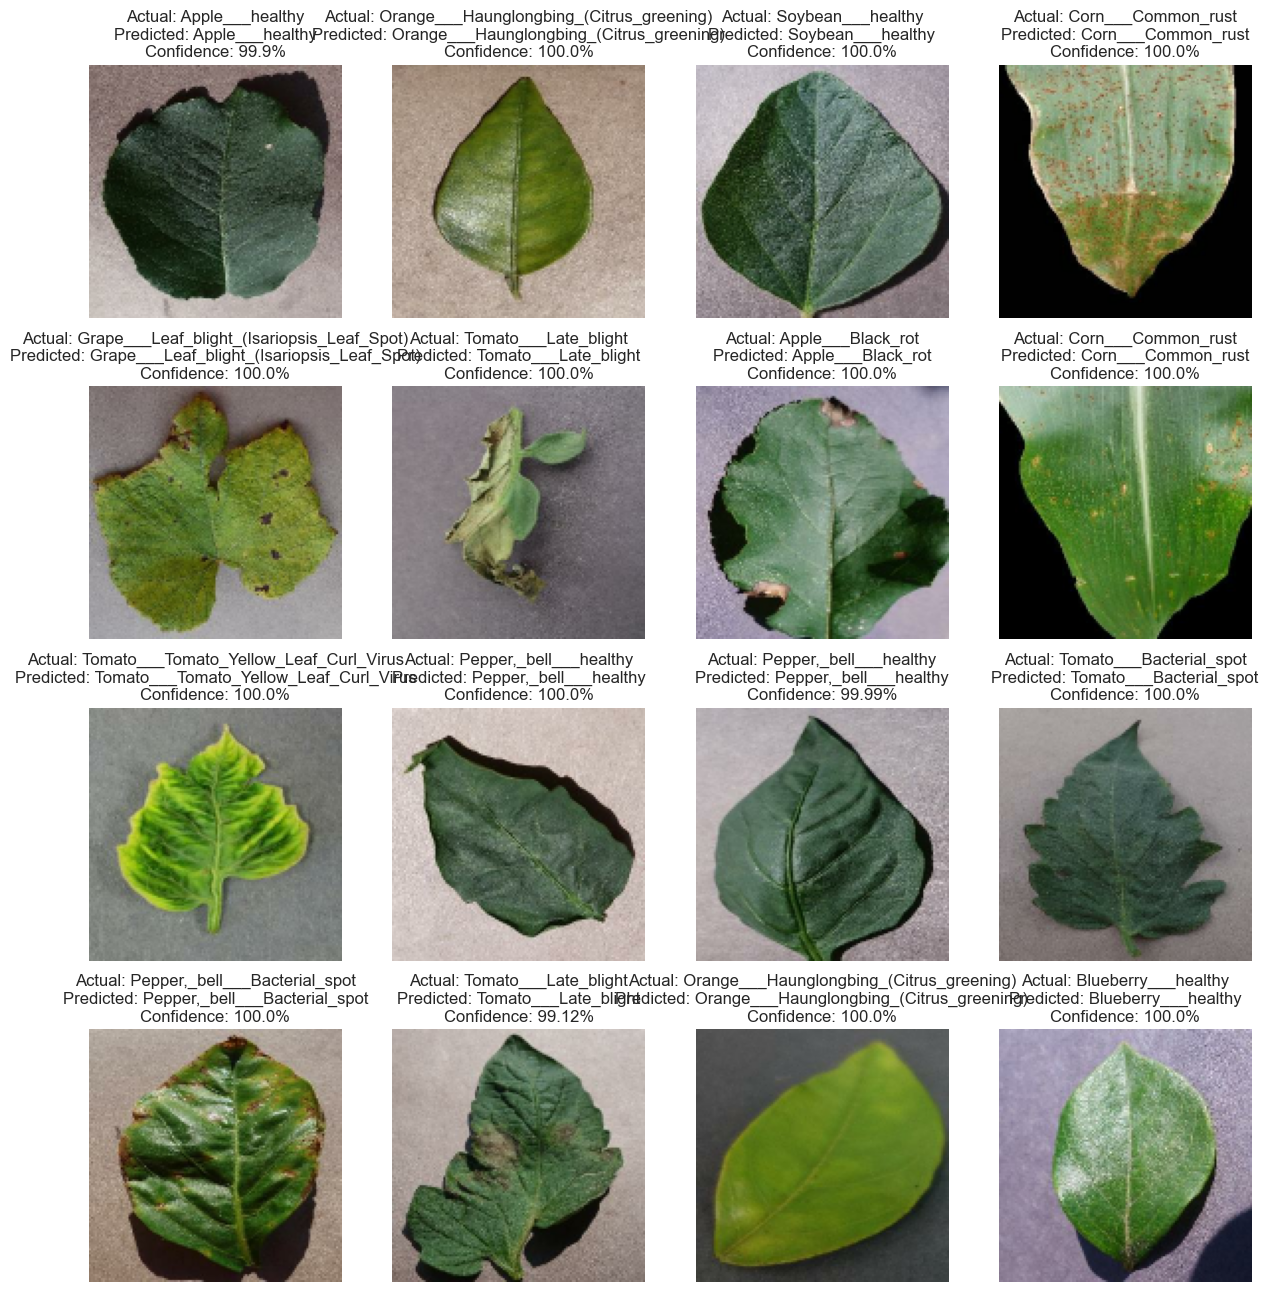

In [23]:
plt.figure(figsize=(15, 16))
for images, labels in test_ds.take(1):
    for i in range(16):
        ax = plt.subplot(4, 4, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))

        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]

        plt.title(f"Actual: {actual_class}\nPredicted: {predicted_class}\nConfidence: {confidence}%")
        plt.axis("off")
plt.show()

#### **Create a confusion metrics**

In [24]:
true_labels = []
predicted_labels = []

# Iterate over the test dataset
for images, labels in test_ds:
    for i in range(len(images)):
        # Get the true label for the image
        true_label = class_names[labels[i].numpy()]
        true_labels.append(true_label)

        # Predict the label for the image using the predict function
        predicted_label, _ = predict(model, images[i].numpy())
        predicted_labels.append(predicted_label)

# Create the confusion matrix
cm = confusion_matrix(true_labels, predicted_labels, labels=class_names)
print(cm)

1/1 [==============================] - 0s 24ms/step
[[ 99   0   0 ...   0   0   0]
 [  0  94   0 ...   0   0   0]
 [  0   0  99 ...   0   0   0]
 ...
 [  0   0   0 ... 566   0   0]
 [  0   0   0 ...   0  95   0]
 [  0   0   0 ...   0   0 147]]


#### **Visualize the confusion matrix**

2/2 [==============================] - 0s 103ms/step


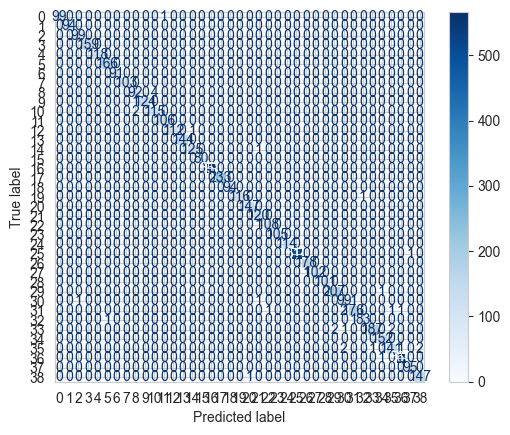

In [25]:
# Predict
y_pred = []
y_true = []

for images, labels in test_ds:
    preds = model.predict(images)
    y_pred.extend(np.argmax(preds, axis=1))
    y_true.extend(labels.numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.show()


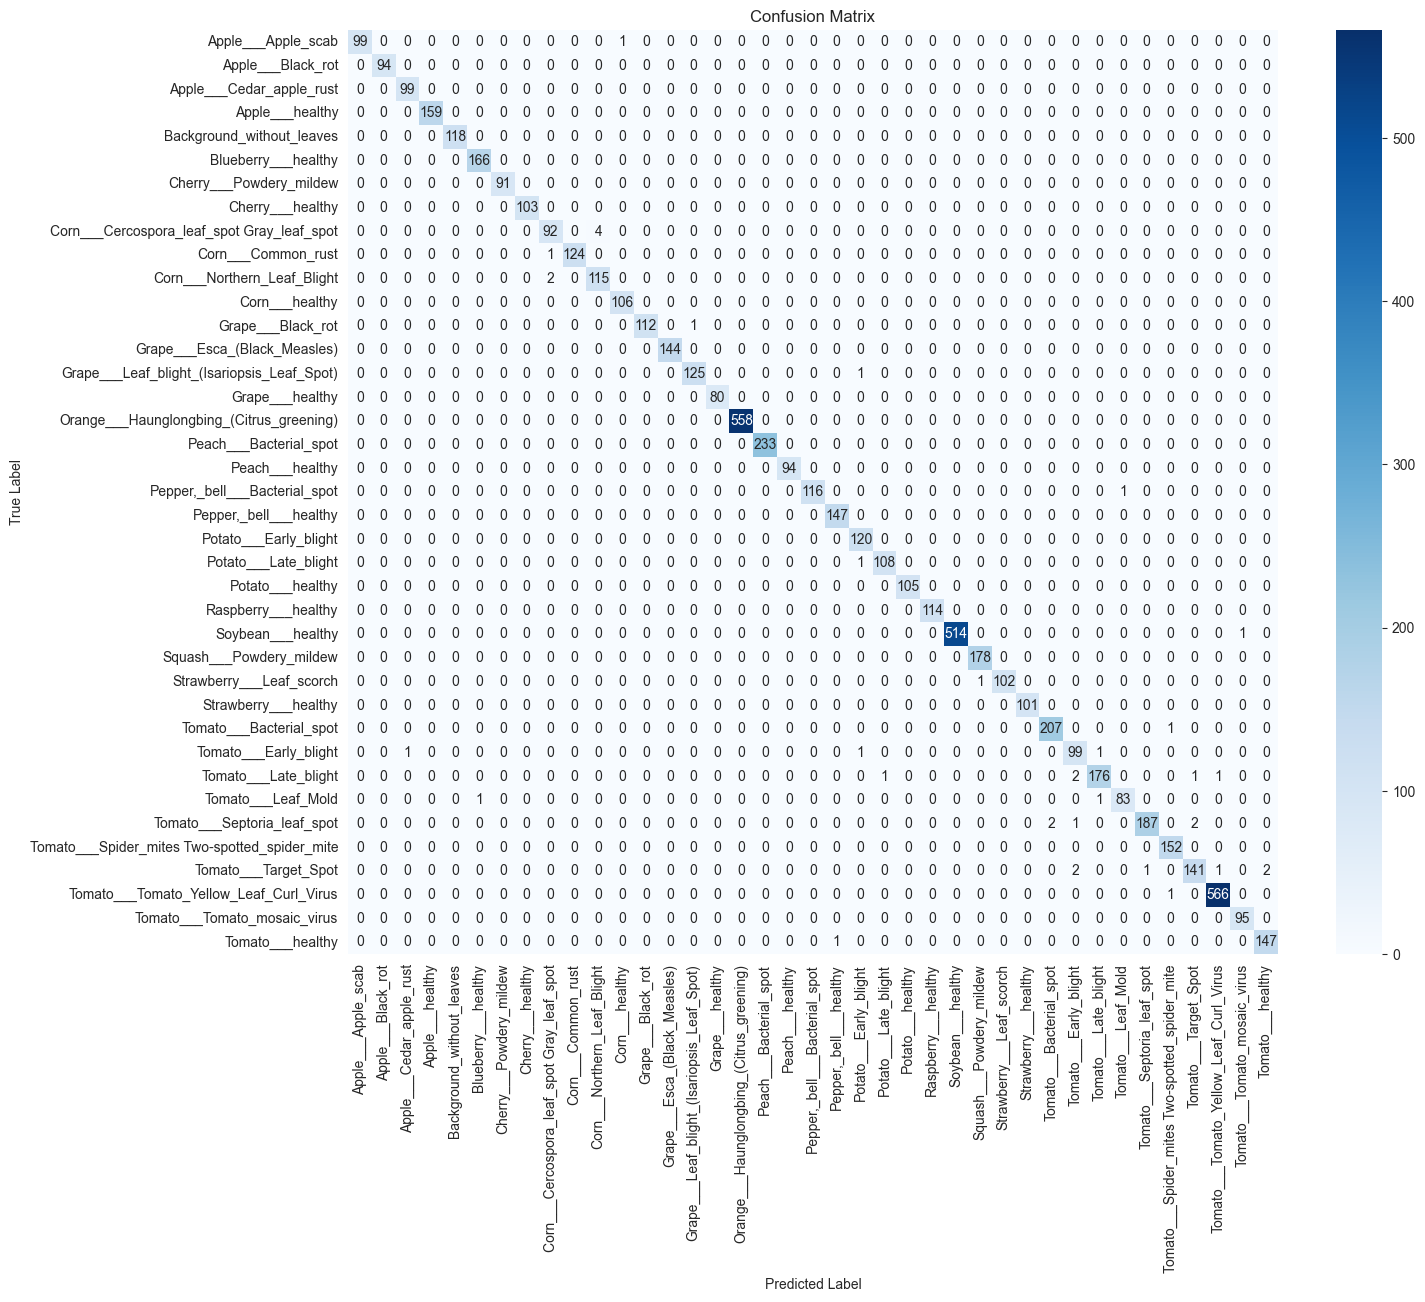

In [26]:
# Visualize the confusion matrix using seaborn
plt.figure(figsize=(15, 12))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [27]:
# Predict on test data
y_true = []
y_pred = []

for images, labels in test_ds:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)
    y_pred.extend(preds)
    y_true.extend(labels.numpy())

2/2 [==============================] - 0s 109ms/step


In [28]:
# Precision, Recall, F1
precision = precision_score(y_true, y_pred, average='weighted')
recall = recall_score(y_true, y_pred, average='weighted')
f1 = f1_score(y_true, y_pred, average='weighted')

print(f"\nPrecision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1 Score:  {f1:.4f}")


Precision: 0.9939
Recall:    0.9939
F1 Score:  0.9939


In [29]:
# Optional: Detailed Classification Report
print("\nClassification Report:")
print(classification_report(y_true, y_pred))


Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99       100
           1       1.00      1.00      1.00        94
           2       0.99      1.00      0.99        99
           3       1.00      1.00      1.00       159
           4       1.00      1.00      1.00       118
           5       0.99      1.00      1.00       166
           6       1.00      1.00      1.00        91
           7       1.00      1.00      1.00       103
           8       0.97      0.96      0.96        96
           9       1.00      0.99      1.00       125
          10       0.97      0.98      0.97       117
          11       0.99      1.00      1.00       106
          12       1.00      0.99      1.00       113
          13       1.00      1.00      1.00       144
          14       0.99      0.99      0.99       126
          15       1.00      1.00      1.00        80
          16       1.00      1.00      1.00       558
   

In [30]:
# Save the final model in both .h5 and .keras formats
model.save('Val_Loss_saved_models/Plant_Disease_Final.h5')
model.save('Val_Loss_saved_models/Plant_Disease_Final.keras')

In [31]:
# # Save the full model in SavedModel format
# #This saves everything (architecture + weights + optimizer state) — ready for inference, serving, or deployment anywhere! 
# model.save('saved_model/Full_plant_disease_model')

# # Load the SavedModel
# model = tf.keras.models.load_model('saved_model/plant_disease_model')


In [32]:
MODEL = load_model('Val_Loss_saved_models/Plant_Disease_Final.keras')